### Factors Driving Life Expectancy : Do immunization matters?

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from fancyimpute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest,  f_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import plot_importance

import os

from library.sb_utils import save_file

In [40]:
sns.set()
sns.set_context("notebook")

### Import dataset 

In [41]:
df = pd.read_csv("../data/life_exp_clean_encod.csv")

In [42]:
df.head(2)

,Country,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,...,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,population,Status_Developed,Status_Developing
0,Afghanistan,2015,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,...,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,17.334091,0,1
1,Afghanistan,2014,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,...,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,12.699494,0,1


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2928 non-null   object 
 1   Year                             2928 non-null   int64  
 2   Life_expectancy                  2928 non-null   float64
 3   Adult_Mortality                  2928 non-null   float64
 4   infant_deaths                    2090 non-null   float64
 5   Alcohol                          2735 non-null   float64
 6   percentage_expenditure           2322 non-null   float64
 7   Hepatitis_B                      2375 non-null   float64
 8   Measles                          1955 non-null   float64
 9   BMI                              2896 non-null   float64
 10  under_five_deaths                2153 non-null   float64
 11  Polio                            2909 non-null   float64
 12  Total_expenditure   

In [44]:
df = df.drop(columns='Country')

In [45]:
# define X and y
X = df.drop(columns='Life_expectancy')
y = df.Life_expectancy

In [46]:
# split the dataset     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [47]:
X_train.shape, X_test.shape

((2049, 22), (879, 22))

In [48]:
# traitement of missing data with MICE Imputation
mice_imputer = IterativeImputer()
X_train_imput = mice_imputer.fit_transform(X_train)
X_test_imput = mice_imputer.transform(X_test)

In [49]:
# scale the date
scaler = StandardScaler()
X_train_imput_scale = scaler.fit_transform(X_train_imput)
X_test_imput_scale = scaler.transform(X_test_imput)

###  Modeling


##### Function to evaluate the model

In [50]:
def model_eval(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

### 1. Model     Simple linear_regression 

In [51]:
pipe = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [52]:
# define the k range to investigate
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [53]:
reg_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=10, n_jobs=-1)

In [54]:
reg_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000002477C893670>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22]})

In [55]:
#Print the `best_params_` attribute of 'red_grid_cv`
reg_grid_cv.best_params_

{'selectkbest__k': 22}

In [56]:
score_mean = reg_grid_cv.cv_results_['mean_test_score']
score_std = reg_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in reg_grid_cv.cv_results_['param_selectkbest__k']]
best_k = reg_grid_cv.best_params_['selectkbest__k']

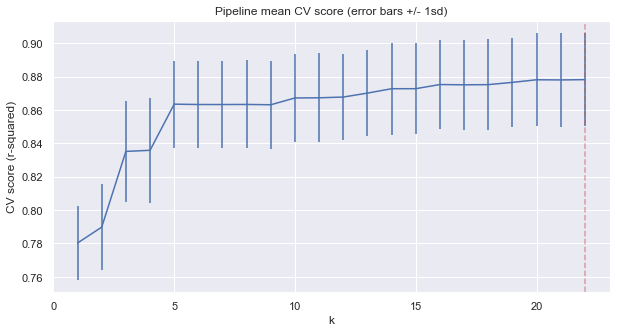

In [57]:
best_k = reg_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for k is 20

In [58]:
# mask to select the most useful features 
selected_features= reg_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
selected_features

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [59]:
coefs = reg_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected_features]
pd.Series(coefs, index=features).sort_values(ascending=False)

Income_composition_of_resources    7.426575
infant_deaths                      7.162289
percentage_expenditure             1.161047
Total_expenditure                  0.532864
Diphtheria                         0.316596
Polio                              0.278216
Status_Developed                   0.094546
Hepatitis_B                        0.081086
Year                               0.051593
thinness__1_19_years               0.044172
population                         0.019159
thinness_5_9_years                -0.072158
Measles                           -0.073517
BMI                               -0.093686
Status_Developing                 -0.094546
Population                        -0.097318
Alcohol                           -0.531740
Schooling                         -1.049590
GDP                               -1.097731
Adult_Mortality                   -1.619040
HIV/AIDS                          -1.869034
under_five_deaths                 -7.305617
dtype: float64

Text(0.5, 1.0, 'Feature importance')

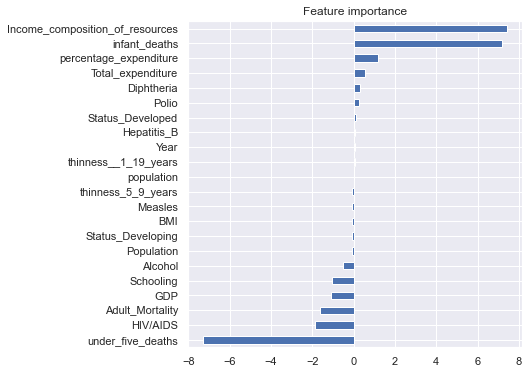

In [158]:
coef_features=pd.Series(coefs, index=features).sort_values(ascending=True)
coef_features = pd.DataFrame(coef_features)
plt.figure(figsize=(6, 6))
coef_features[0].plot(kind='barh')
plt.title('Feature importance')

#### Note:
From this result, the best positive features here are Income_composition_of_resources , followed by infant_deaths. 

Features which negatively influence life expectancy are under_five_deaths of children (the most important) , next it is HIV/AIDS and Adult_Mortality.

We realise that immunization factors are also present among the positive features (come in 6th , 7th and 8th positions) even if their strength is not high as compared to the first features. 

It is also important to highlight the fact that the feature: status of the country (either developed or developing) has an impact on the model. 
May, it would be great to expect if a dataset with only developing countries would highlight the importance of immunization as we explore in the EDA.


In [61]:
reg_grid_cv.best_estimator_

Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=22,
                             score_func=<function f_regression at 0x000002477C893670>)),
                ('linearregression', LinearRegression())])

In [62]:
lin_reg = reg_grid_cv.best_estimator_

#### Assess performance on train and test data

In [63]:
predicted_train = lin_reg.predict(X_train)
predicted_test = lin_reg.predict(X_test)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.4208078215853304
MSE: 11.0915178488907
RMSE: 3.3303930472078966
R2 Square 0.8761225419581659
__________________________________
MAE: 2.434775909873193
MSE: 10.828904218566597
RMSE: 3.2907300434047455
R2 Square 0.8811477237735879
__________________________________


#### Assessing performance using cross-validation

In [64]:
cv_results = cross_validate(reg_grid_cv.best_estimator_, X_train, y_train, cv=5)

In [65]:
cv_scores = cv_results['test_score']
np.mean(cv_scores), np.std(cv_scores)

(0.8794806258417486, 0.013053091581342203)

### 2. Model linear regression with PCA

In [66]:
pipe3 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    PCA(n_components=19),
    LinearRegression())

In [67]:
lin_reg2 = pipe3.fit(X_train, y_train)

#### Model Evaluation

In [68]:
predicted_train = lin_reg2.predict(X_train)
predicted_test = lin_reg2.predict(X_test)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.6752494795915207
MSE: 12.880212033304321
RMSE: 3.5889012292489078
R2 Square 0.856145214075893
__________________________________
MAE: 2.7194090026788427
MSE: 12.856261215405254
RMSE: 3.585562886828964
R2 Square 0.8588965348319876
__________________________________


### 3. Model: Ridge regression 

In [69]:
# Perform 5-fold cross-validation: ridge_cv
alpha = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 20.0, 40.0, 60.0, 80.0 ,100.0]
for x in alpha:
    ridge = Ridge(alpha=10)
    ridge_cv = cross_val_score(ridge, X_train_imput_scale, y_train, cv=10, n_jobs=-1)
    print( 'cross-validated scores of ridge regression for alpha', x ,'is :', np.mean(ridge_cv))

cross-validated scores of ridge regression for alpha 1e-05 is : 0.8760049691829186
cross-validated scores of ridge regression for alpha 0.0001 is : 0.8760049691829186
cross-validated scores of ridge regression for alpha 0.001 is : 0.8760049691829186
cross-validated scores of ridge regression for alpha 0.01 is : 0.8760049691829186
cross-validated scores of ridge regression for alpha 0.1 is : 0.8760049691829186
cross-validated scores of ridge regression for alpha 0.0 is : 0.8760049691829186
cross-validated scores of ridge regression for alpha 1.0 is : 0.8760049691829186
cross-validated scores of ridge regression for alpha 10.0 is : 0.8760049691829186
cross-validated scores of ridge regression for alpha 20.0 is : 0.8760049691829186
cross-validated scores of ridge regression for alpha 40.0 is : 0.8760049691829186
cross-validated scores of ridge regression for alpha 60.0 is : 0.8760049691829186
cross-validated scores of ridge regression for alpha 80.0 is : 0.8760049691829186
cross-validated

In [70]:
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 20.0, 40.0, 60.0, 80.0 ,100.0]

In [71]:
pipe4 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    Ridge())

In [72]:
ridge_grid_cv = GridSearchCV(pipe4, grid, cv=10, n_jobs=-1)

#####  Model: Ridge regression 

In [73]:
pipe5 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    Ridge(alpha=0.5))

In [74]:
ridge_reg = pipe5.fit(X_train, y_train)

In [75]:
predicted_train = ridge_reg.predict(X_train)
predicted_test = ridge_reg.predict(X_test)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.419506794922075
MSE: 11.080545923968375
RMSE: 3.328745397889177
R2 Square 0.8762450837227576
__________________________________
MAE: 2.4361589115692093
MSE: 10.830899453949987
RMSE: 3.291033189433067
R2 Square 0.8811258251343408
__________________________________


### 4.ElasticNet regression

In [76]:
#  hyperparameter grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1.1, 0.1)

In [77]:
grid

{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

###### identify the best parameters

In [78]:
elastic_net = ElasticNet()

EL_grid_cv0 = GridSearchCV(elastic_net, grid, cv=5, n_jobs=-1)

EL_grid_cv0 .fit(X_train_imput_scale, y_train)

C:\Users\mirei\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\mirei\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mirei\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11094.221605042218, tolerance: 18.668910220595414
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0,
                                   10.0, 100.0],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [79]:
print("Tuned ElasticNet l1 ratio: {}".format(EL_grid_cv0.best_params_))

Tuned ElasticNet l1 ratio: {'alpha': 0.0, 'l1_ratio': 0.0}


##### Run the model with the best paramters and assessing the performance

In [80]:
elastic_net = ElasticNet(alpha = 0.0, l1_ratio = 0.0)

elastic_net_CV = cross_val_score(elastic_net, X_train_imput_scale, y_train, cv=10, n_jobs=-1)

print( 'cross-validation scores of elastic_net regression is ', np.mean(elastic_net_CV))

cross-validation scores of elastic_net regression is  0.8777380250763078


In [81]:
Elastic_net = elastic_net.fit( X_train_imput_scale, y_train)

C:\Users\mirei\AppData\Local\Temp/ipykernel_124856/2293483320.py:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  Elastic_net = elastic_net.fit( X_train_imput_scale, y_train)
C:\Users\mirei\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mirei\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11094.221605042218, tolerance: 18.668910220595414
  model = cd_fast.enet_coordinate_descent(


In [82]:
predicted_train = Elastic_net.predict(X_train_imput_scale)
predicted_test = Elastic_net.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.4206974867823945
MSE: 11.09084192780402
RMSE: 3.330291567986806
R2 Square 0.8761300910950104
__________________________________
MAE: 2.4348646539514602
MSE: 10.828913230885519
RMSE: 3.2907314127539364
R2 Square 0.8811476248591827
__________________________________


### 5.  Decision tree for regression

In [83]:
param_rf={'max_depth':[4,6,8, 10, 12, 14, 16], 'min_samples_leaf': [0.1, 0.2, 0.5, 1, 1.5, 2], 
          'max_features': [0.2,0.4, 0.6, 0.8, 1.0]}

In [84]:
dt = DecisionTreeRegressor(random_state=1)
dt_grid_CV= GridSearchCV(estimator= dt ,param_grid=param_rf, cv=10,
                          scoring='accuracy',  n_jobs=-1)
# Fit dt to the training set
dt_grid_CV=dt_grid_CV.fit(X_train_imput_scale, y_train)

C:\Users\mirei\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  wa

In [85]:
best_dt_param = dt_grid_CV.best_params_
best_dt_param

{'max_depth': 4, 'max_features': 0.2, 'min_samples_leaf': 0.1}

In [86]:
model_dt = dt_grid_CV.best_estimator_

In [87]:
predicted_train = dt_grid_CV.predict(X_train_imput_scale)
predicted_test = dt_grid_CV.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 3.863532769202153
MSE: 27.570816497385476
RMSE: 5.250791987632482
R2 Square 0.6920707598035769
__________________________________
MAE: 3.8674476846519696
MSE: 27.097628249072212
RMSE: 5.205538228566976
R2 Square 0.7025908870615473
__________________________________


### 6.Random Forest Model

https://medium.datadriveninvestor.com/random-forest-regression-9871bc9a25eb

#### Simple model of random forest 

In [88]:
rf_reg1 = RandomForestRegressor(n_estimators = 200, max_depth= 4, max_features=0.4, n_jobs=-1, random_state=1)
rf_reg1.fit(X_train_imput_scale, y_train)

RandomForestRegressor(max_depth=4, max_features=0.4, n_estimators=200,
                      n_jobs=-1, random_state=1)

##### evaluate the model

In [89]:
predicted_train = rf_reg1.predict(X_train_imput_scale)
predicted_test = rf_reg1.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.0700118418698006
MSE: 8.310518575927087
RMSE: 2.8827970056747123
R2 Square 0.9071825939225934
__________________________________
MAE: 1.965666683326224
MSE: 7.371327708600075
RMSE: 2.715018914961749
R2 Square 0.9190962391674096
__________________________________


#### 2nd model of random forest 

In [90]:
rf_reg2 = RandomForestRegressor(n_estimators = 200, max_depth= 10, max_features=0.4, n_jobs=-1, random_state=1)
rf_reg2.fit(X_train_imput_scale, y_train)

RandomForestRegressor(max_depth=10, max_features=0.4, n_estimators=200,
                      n_jobs=-1, random_state=1)

In [91]:
# evaluate the model
predicted_train = rf_reg2.predict(X_train_imput_scale)
predicted_test = rf_reg2.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.3513974668413375
MSE: 4.041975871124836
RMSE: 2.010466580454606
R2 Square 0.9548565216048
__________________________________
MAE: 0.7672918255836191
MSE: 1.2450402530416385
RMSE: 1.115813717894541
R2 Square 0.9863351023260695
__________________________________


#### 3 random forest model

In [92]:
rf_reg3 = RandomForestRegressor(n_estimators = 100, max_depth=7, max_features=0.3, n_jobs=-1, random_state=1)
rf_reg3.fit(X_train_imput_scale, y_train)

RandomForestRegressor(max_depth=7, max_features=0.3, n_jobs=-1, random_state=1)

In [93]:
# evaluate the model
predicted_train = rf_reg3.predict(X_train_imput_scale)
predicted_test = rf_reg3.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.612885197542225
MSE: 5.335150864676197
RMSE: 2.3097945503174513
R2 Square 0.9404134820508917
__________________________________
MAE: 1.3030944899636046
MSE: 3.2951183990677504
RMSE: 1.8152460987611985
R2 Square 0.9638345381711602
__________________________________


#### 4th model of random forest with GridSearchCV

In [94]:
param_rf={'max_depth':[4, 5, 6, 7, 8],'n_estimators':[50, 75, 100, 150, 175, 200], 
          'min_samples_leaf': [0.1, 0.2, 0.5, 0.7, 0.9, 1], 'max_features': [0.3, 0.4, 0.5, 0.6]},

In [95]:
# Perform Grid-Search
RF_grid_CV= GridSearchCV(estimator= RandomForestRegressor(random_state=1) ,param_grid=param_rf, cv=5, 
                          scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [96]:
RF_grid_CV.fit(X_train_imput_scale, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


C:\Users\mirei\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-16.58236921 -16.55921532 -16.7002158  -16.35878103 -16.37413278
 -16.44962042 -25.92406931 -25.71796348 -25.76196886 -25.45517732
 -25.41245263 -25.55134703 -91.12647702 -91.12889565 -91.12945785
 -91.13285487 -91.13255861 -91.13252833          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  -9.24268813  -9.27774694  -9.2038039   -9.08749338  -9.09125255
  -9.08105114 -15.99693078 -15.78755285 -15.81188881 -15.7081208
 -15.63604638 -15.69971656 -24.68246488 -24.69641626 -24.80918861
 -24.38481714 -24.30437233 -24.41154178 -91.12647702 -91.12889565
 -91.12945785 -91.13285487 -91.13255861 -91.13252833          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=({'max_depth': [4, 5, 6, 7, 8],
                          'max_features': [0.3, 0.4, 0.5, 0.6],
                          'min_samples_leaf': [0.1, 0.2, 0.5, 0.7, 0.9, 1],
                          'n_estimators': [50, 75, 100, 150, 175, 200]},),
             scoring='neg_mean_squared_error', verbose=1)

In [97]:
best_rf_param = RF_grid_CV.best_params_
best_rf_param

{'max_depth': 8,
 'max_features': 0.6,
 'min_samples_leaf': 1,
 'n_estimators': 200}

In [98]:
rf_reg4 = RF_grid_CV.best_estimator_

In [99]:
predicted_train = rf_reg4.predict(X_train_imput_scale)
predicted_test = rf_reg4.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.44459017879459
MSE: 4.469747130368998
RMSE: 2.1141776487251485
R2 Square 0.9500788872953694
__________________________________
MAE: 0.9958535025438301
MSE: 2.03063826173892
RMSE: 1.425004653234129
R2 Square 0.9777127976451839
__________________________________


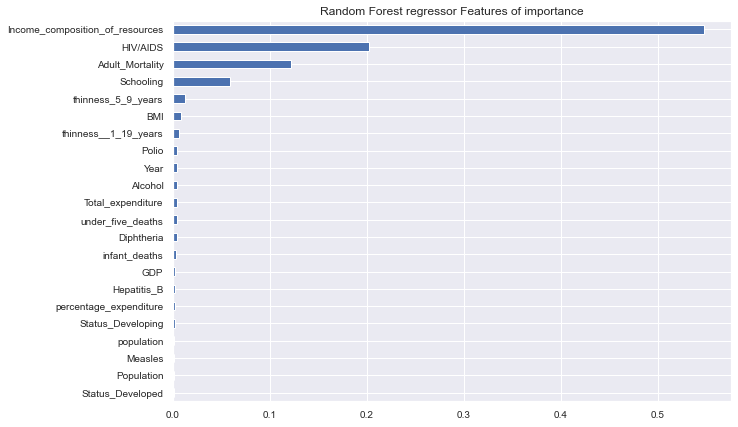

In [100]:
Important_features =  pd.Series(rf_reg4.feature_importances_, index = X_train.columns).sort_values()
Important_features.plot(kind='barh', figsize=(10,7) , fontsize=10)
plt.title('Random Forest regressor Features of importance')
plt.show()

In [101]:
# Perform K-Fold CV for Random forest regressor 
scores = cross_val_score(rf_reg4, X_train_imput_scale, y_train, cv= 5)

In [102]:
np.mean(scores)

0.9500902625279759

In [103]:
scores2 = cross_validate(rf_reg4, X_train_imput_scale, y_train, cv=5)

In [104]:
scores2 = cv_results['test_score']
np.mean(scores2), np.std(scores2)

(0.8794806258417486, 0.013053091581342203)

In [105]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1500, num = 10)]
max_features =  [x for x in np.linspace(start = 0.2, stop = 1.0, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 344, 488, 633, 777, 922, 1066, 1211, 1355, 1500], 'max_features': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 7, 10], 'min_samples_leaf': [1, 2, 4, 6], 'bootstrap': [True, False]}


In [106]:
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train_imput_scale, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': [0.2, 0.4,
                                                         0.6000000000000001,
                                                         0.8, 1.0],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 7, 10],
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, verbose=2)

In [107]:
rf_random.best_params_

{'n_estimators': 488,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 0.4,
 'max_depth': 20,
 'bootstrap': False}

In [108]:
rf_reg6 = rf_random.best_estimator_

In [109]:
predicted_train = rf_reg6.predict(X_train_imput_scale)
predicted_test = rf_reg6.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.1091016387224406
MSE: 3.2272588913448503
RMSE: 1.7964573168725302
R2 Square 0.963955823418461
__________________________________
MAE: 0.005905252257301221
MSE: 0.0002084371422870615
RMSE: 0.01443735232953264
R2 Square 0.9999977123051131
__________________________________


In [110]:
# Perform K-Fold CV
rf_scores = cross_val_score(rf_random.best_estimator_, X_train_imput_scale, y_train, cv=5)

In [111]:
 np.mean(rf_scores), np.std(rf_scores)

(0.9606393823264326, 0.007604582714427789)

##### 1st Gradien Boosting Model 

In [112]:
grdB = GradientBoostingRegressor(n_estimators = 150, max_depth = 3, random_state=1)
grdB.fit(X_train_imput_scale, y_train)

GradientBoostingRegressor(n_estimators=150, random_state=1)

In [113]:
predicted_train = grdB.predict(X_train_imput_scale)
predicted_test = grdB.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.5439771100187263
MSE: 4.979547887326709
RMSE: 2.2314900598762946
R2 Square 0.9443850929256439
__________________________________
MAE: 1.1459256178294823
MSE: 2.581168057259521
RMSE: 1.6066013996195574
R2 Square 0.9716704762793804
__________________________________


#### 2nd Gradient Boost Model

In [114]:
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 150, num = 5)]
max_features =  [x for x in np.linspace(start = 0.2, stop = 1.0, num = 5)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [6, 8, 10, 12]
min_samples_leaf = [4, 6, 8, 10]
learning_rate = [x for x in np.linspace(0.01, 0.3, num = 5)]
criterion = ['mse',]


grd_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'learning_rate': learning_rate}
print(grd_grid)

{'n_estimators': [25, 56, 87, 118, 150], 'max_features': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [6, 8, 10, 12], 'min_samples_leaf': [4, 6, 8, 10], 'learning_rate': [0.01, 0.08249999999999999, 0.155, 0.22749999999999998, 0.3]}


In [115]:
# with RandomizedSearchCV
grd = GradientBoostingRegressor()

grd_Boost = RandomizedSearchCV(estimator = grd, param_distributions= grd_grid,  cv = 5, verbose=1, random_state=1, n_jobs = -1)

In [116]:
# with GridSearchCV
grd = GradientBoostingRegressor(random_state = 1)

grd_Boost2 = GridSearchCV(estimator = grd, param_grid= grd_grid, scoring='neg_mean_squared_error', cv = 5, verbose=1, n_jobs = -1)

In [117]:
grd_Boost.fit(X_train_imput_scale, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01,
                                                          0.08249999999999999,
                                                          0.155,
                                                          0.22749999999999998,
                                                          0.3],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': [0.2, 0.4,
                                                         0.6000000000000001,
                                                         0.8, 1.0],
                                        'min_samples_leaf': [4, 6, 8, 10],
                                        'min_samples_split': [6, 8, 10, 12],
                                        'n_estimators': [25, 56, 87, 1

In [118]:
grd_Boost2.fit(X_train_imput_scale, y_train)

Fitting 5 folds for each of 20000 candidates, totalling 100000 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.08249999999999999, 0.155,
                                           0.22749999999999998, 0.3],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [0.2, 0.4, 0.6000000000000001, 0.8,
                                          1.0],
                         'min_samples_leaf': [4, 6, 8, 10],
                         'min_samples_split': [6, 8, 10, 12],
                         'n_estimators': [25, 56, 87, 118, 150]},
             scoring='neg_mean_squared_error', verbose=1)

In [119]:
grd_Boost.best_params_

{'n_estimators': 118,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_features': 0.6000000000000001,
 'max_depth': 10,
 'learning_rate': 0.08249999999999999}

#grd_Boost.best_params_ = {'n_estimators': 118,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_features': 0.6000000000000001,
 'max_depth': 10,
 'learning_rate': 0.08249999999999999}

In [120]:
grd_Boost2.best_params_

{'learning_rate': 0.08249999999999999,
 'max_depth': 10,
 'max_features': 0.6000000000000001,
 'min_samples_leaf': 8,
 'min_samples_split': 6,
 'n_estimators': 150}

#grd_Boost2.best_params_ = {'learning_rate': 0.08249999999999999,
 'max_depth': 7,
 'max_features': 0.8,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 150}

In [121]:
grd_Boost.best_estimator_

GradientBoostingRegressor(learning_rate=0.08249999999999999, max_depth=10,
                          max_features=0.6000000000000001, min_samples_leaf=8,
                          min_samples_split=10, n_estimators=118)

In [122]:
grd_Boost2.best_estimator_

GradientBoostingRegressor(learning_rate=0.08249999999999999, max_depth=10,
                          max_features=0.6000000000000001, min_samples_leaf=8,
                          min_samples_split=6, n_estimators=150,
                          random_state=1)

In [123]:
GRD_Boost= grd_Boost.best_estimator_

In [124]:
GRD_Boost2= grd_Boost2.best_estimator_

In [125]:
predicted_train = GRD_Boost.predict(X_train_imput_scale)
predicted_test = GRD_Boost.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.1519766729096745
MSE: 3.260905880476566
RMSE: 1.805797851498491
R2 Square 0.9635800314356879
__________________________________
MAE: 0.1844318202979674
MSE: 0.10333125400065835
RMSE: 0.32145179109884947
R2 Square 0.9988658912762151
__________________________________


In [126]:
predicted_train = GRD_Boost2.predict(X_train_imput_scale)
predicted_test = GRD_Boost2.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.1706820830302334
MSE: 3.462588091881295
RMSE: 1.8608030771366686
R2 Square 0.9613275101828305
__________________________________
MAE: 0.14416879991134438
MSE: 0.05967600363504632
RMSE: 0.24428672423004555
R2 Square 0.9993450280171506
__________________________________


In [164]:
feature_importance = GRD_Boost.feature_importances_
feature_importance

array([0.00463862, 0.15025896, 0.00362304, 0.00519675, 0.0032392 ,
       0.00328907, 0.00203342, 0.00582728, 0.00447337, 0.00407784,
       0.004617  , 0.00399472, 0.10100628, 0.00261785, 0.0017947 ,
       0.00681784, 0.00682902, 0.54656548, 0.13461015, 0.00216925,
       0.00159325, 0.00072692])

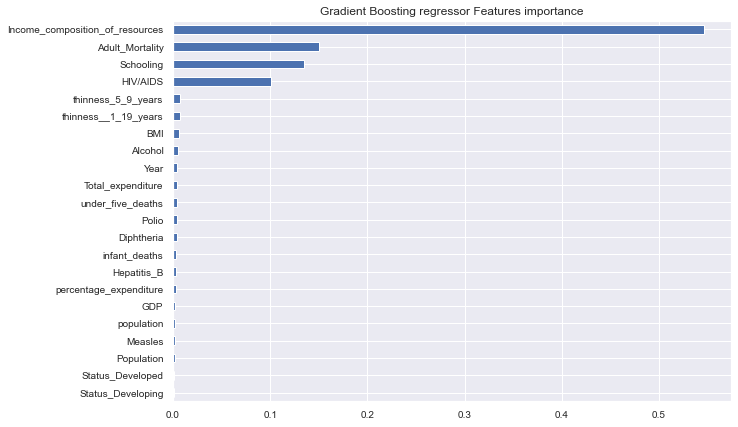

In [165]:
Important_features =  pd.Series(GRD_Boost.feature_importances_, index = X_train.columns).sort_values()
Important_features.plot(kind='barh', figsize=(10,7) , fontsize=10)
plt.title('Gradient Boosting regressor Features importance')
plt.show()

#### XGBoost regression model

In [127]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror',  learning_rate= 0.04, max_depth=5,
                       n_estimators= 200, n_jobs=-1 )
xgbr.fit(X_train_imput_scale, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.04, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [128]:
predicted_train = xgbr.predict(X_train_imput_scale)
predicted_test = xgbr.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.375659246520649
MSE: 4.097322079660356
RMSE: 2.0241842998255755
R2 Square 0.9542383782885252
__________________________________
MAE: 0.8634313863565307
MSE: 1.4860088169722818
RMSE: 1.2190196130383963
R2 Square 0.9836903599085437
__________________________________


### 7. Mix of model, which model to select for ensemble model

In [129]:
alg= [RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), 
      DecisionTreeRegressor(), LinearRegression(), SVR(), LassoCV()]

In [130]:
for i in alg:
    model= i
    model.fit(X_train_imput_scale, y_train)
    y_pred1= model.predict(X_test_imput_scale)
    y_pred2= model.predict(X_train_imput_scale)
    print(i, model_eval(y_train, y_pred2))
    print("*"*50)
    print(i, model_eval(y_test, y_pred1))
    print("="*70)

MAE: 0.45084577842850304
MSE: 0.5300682562225492
RMSE: 0.7280578659849429
R2 Square 0.9941822535747061
__________________________________
RandomForestRegressor() None
**************************************************
MAE: 1.2304664391353806
MSE: 3.662692309442542
RMSE: 1.913816163962083
R2 Square 0.959092613016126
__________________________________
RandomForestRegressor() None
MAE: 2.2953535651939294
MSE: 8.16917965622423
RMSE: 2.8581776810100927
R2 Square 0.9103394417894972
__________________________________
AdaBoostRegressor() None
**************************************************
MAE: 2.4280898387301253
MSE: 9.421705937239107
RMSE: 3.069479750257217
R2 Square 0.8947721134452696
__________________________________
AdaBoostRegressor() None
MAE: 1.26884771695024
MSE: 3.1386302221411175
RMSE: 1.7716179673228418
R2 Square 0.9655520689254135
__________________________________
GradientBoostingRegressor() None
**************************************************
MAE: 1.5880482137773986
MSE: 

### 7. Ensemble learning model  

In [131]:
# Train classifiers
reg1 = GradientBoostingRegressor(random_state=47)
reg2 = RandomForestRegressor(random_state=47)
reg3 = LinearRegression()

reg1.fit( X_train_imput_scale , y_train)
reg2.fit( X_train_imput_scale , y_train)
reg3.fit( X_train_imput_scale , y_train)

voting = VotingRegressor([("gb", reg1), ("rf", reg2), ("lr", reg3)])
voting.fit( X_train_imput_scale , y_train)

VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=47)),
                            ('rf', RandomForestRegressor(random_state=47)),
                            ('lr', LinearRegression())])

In [132]:
predicted_train = voting.predict(X_train_imput_scale)
predicted_test = voting.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.5808207595054748
MSE: 5.260257234321089
RMSE: 2.293525067297301
R2 Square 0.9412499439921979
__________________________________
MAE: 1.2560820940355506
MSE: 3.1279214995658315
RMSE: 1.7685930847896674
R2 Square 0.9656696021520319
__________________________________


In [133]:
#voting.get_params()

### Selection of the best model

In [134]:
models_liste = [lin_reg, lin_reg2, ridge_reg, Elastic_net, model_dt, rf_reg1, rf_reg2, rf_reg3, rf_reg4,
               grdB, GRD_Boost,GRD_Boost2, xgbr, voting]

In [135]:
#GRD_Boost2

In [136]:
for model in models_liste[0:3]:
    model=model
    y_pred1= model.predict(X_test)
    y_pred2= model.predict(X_train)
    print(model)
    print('EVALUATION FOR TRAINING DATA SET')
    print(model_eval(y_train, y_pred2))
    print("*"*50)
    print('EVALUATION FOR TESTING DATA SET')    
    print(model_eval(y_test, y_pred1))
    print("="*70)
for model in models_liste[3:]:
    model=model
    y_pred1= model.predict(X_test_imput_scale)
    y_pred2= model.predict(X_train_imput_scale)
    print(model)
    print('EVALUATION FOR TRAINING DATA SET')
    print(model_eval(y_train, y_pred2))
    print("*"*50)
    print('EVALUATION FOR TESTING DATA SET')    
    print(model_eval(y_test, y_pred1))
    print("="*70)

Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=22,
                             score_func=<function f_regression at 0x000002477C893670>)),
                ('linearregression', LinearRegression())])
EVALUATION FOR TRAINING DATA SET
MAE: 2.434775909873193
MSE: 10.828904218566597
RMSE: 3.2907300434047455
R2 Square 0.8811477237735879
__________________________________
None
**************************************************
EVALUATION FOR TESTING DATA SET
MAE: 2.4208078215853304
MSE: 11.0915178488907
RMSE: 3.3303930472078966
R2 Square 0.8761225419581659
__________________________________
None
Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=19)),
                ('linearregression', LinearRegression())])
EVALUATION FOR TRAINING DATA SET
MAE: 2.7194090026788427
M

VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=47)),
                            ('rf', RandomForestRegressor(random_state=47)),
                            ('lr', LinearRegression())])
EVALUATION FOR TRAINING DATA SET
MAE: 1.2560820940355506
MSE: 3.1279214995658315
RMSE: 1.7685930847896674
R2 Square 0.9656696021520319
__________________________________
None
**************************************************
EVALUATION FOR TESTING DATA SET
MAE: 1.5808207595054748
MSE: 5.260257234321089
RMSE: 2.293525067297301
R2 Square 0.9412499439921979
__________________________________
None


In [137]:
def model_eval_dict(true, predicted, model_list, MAE, MSE, RMSE, R2):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    MAE.append(mae)
    MSE.append(mse)
    RMSE.append(rmse)
    R2.append(r2_square)
    return MAE, MSE, RMSE, R2

In [138]:
# evaluation  on train dataset

In [139]:
models_liste = [lin_reg, lin_reg2, ridge_reg, Elastic_net, model_dt, rf_reg1, rf_reg2, rf_reg3, rf_reg4,
               grdB, GRD_Boost,GRD_Boost2, xgbr, voting]

MAE = []
MSE = []
RMSE = []
R2 = []

for model in models_liste:
    if model in  models_liste[0:3]:
        y_pred2= model.predict(X_train)
        model_eval_dict(y_train, y_pred2, models_liste, MAE, MSE, RMSE, R2)   
    if model in models_liste[3:]:
        y_pred2= model.predict(X_train_imput_scale)
        model_eval_dict(y_train, y_pred2, models_liste, MAE, MSE, RMSE, R2)

In [140]:
# compute the dataframe with the value
models = ['linear_reg', 'linear_reg2', 'ridge_reg', 'Elastic_net', 'decision_tree', 'random_forest_reg1','random_forest_reg2', 'random_forest_reg3', 'random_forest_reg4',
               'gradien_boost_1','gradien_boost_2', 'gradien_boost_3', 'XGBRegressor', 'voting']
zipped = list(zip(models,models_liste,MAE, MSE, RMSE, R2))
df_r1 = pd.DataFrame(zipped, columns=['model','model_definition','MAE_tr', 'MSE_tr', 'RMSE_tr', 'R2_tr'])

In [141]:
df_r1

,model,model_definition,MAE_tr,MSE_tr,RMSE_tr,R2_tr
0,linear_reg,"(IterativeImputer(), StandardScaler(), SelectK...",2.434776,10.828904,3.290730,0.881148
1,linear_reg2,"(IterativeImputer(), StandardScaler(), PCA(n_c...",2.719409,12.856261,3.585563,0.858897
2,ridge_reg,"(IterativeImputer(), StandardScaler(), Ridge(a...",2.436159,10.830899,3.291033,0.881126
3,Elastic_net,"ElasticNet(alpha=0.0, l1_ratio=0.0)",2.434865,10.828913,3.290731,0.881148
4,decision_tree,"DecisionTreeRegressor(max_depth=4, max_feature...",3.867448,27.097628,5.205538,0.702591
5,random_forest_reg1,"(DecisionTreeRegressor(max_depth=4, max_featur...",1.965667,7.371328,2.715019,0.919096
6,random_forest_reg2,"(DecisionTreeRegressor(max_depth=10, max_featu...",0.767292,1.245040,1.115814,0.986335
7,random_forest_reg3,"(DecisionTreeRegressor(max_depth=7, max_featur...",1.303094,3.295118,1.815246,0.963835
8,random_forest_reg4,"(DecisionTreeRegressor(max_depth=8, max_featur...",0.995854,2.030638,1.425005,0.977713
9,gradien_boost_1,([DecisionTreeRegressor(criterion='friedman_ms...,1.145926,2.581168,1.606601,0.971670


In [142]:
# evaluation  on test dataset

In [143]:
models_liste = [lin_reg, lin_reg2, ridge_reg, Elastic_net, model_dt, rf_reg1, rf_reg2, rf_reg3, rf_reg4,
               grdB, GRD_Boost,GRD_Boost2, xgbr, voting]

MAE = []
MSE = []
RMSE = []
R2 = []

for model in models_liste:
    if model in  models_liste[0:3]:
        y_pred1= model.predict(X_test)
        model_eval_dict(y_test, y_pred1, models_liste, MAE, MSE, RMSE, R2)
    
    if model in models_liste[3:]:
        y_pred1= model.predict(X_test_imput_scale)
        model_eval_dict(y_test, y_pred1, models_liste, MAE, MSE, RMSE, R2)

In [144]:
zipped = list(zip(MAE, MSE, RMSE, R2))
df_r2 = pd.DataFrame(zipped, columns=['MAE_tt', 'MSE_tt', 'RMSE_tt', 'R2_tt'])

In [145]:
df_r2

,MAE_tt,MSE_tt,RMSE_tt,R2_tt
0,2.420808,11.091518,3.330393,0.876123
1,2.675249,12.880212,3.588901,0.856145
2,2.419507,11.080546,3.328745,0.876245
3,2.420697,11.090842,3.330292,0.876130
4,3.863533,27.570816,5.250792,0.692071
5,2.070012,8.310519,2.882797,0.907183
6,1.351397,4.041976,2.010467,0.954857
7,1.612885,5.335151,2.309795,0.940413
8,1.444590,4.469747,2.114178,0.950079
9,1.543977,4.979548,2.231490,0.944385


In [146]:
# concat the two dataframe (test and train score of all metric)
results = pd.concat([df_r1, df_r2], axis=1)
results

,model,model_definition,MAE_tr,MSE_tr,RMSE_tr,R2_tr,MAE_tt,MSE_tt,RMSE_tt,R2_tt
0,linear_reg,"(IterativeImputer(), StandardScaler(), SelectK...",2.434776,10.828904,3.290730,0.881148,2.420808,11.091518,3.330393,0.876123
1,linear_reg2,"(IterativeImputer(), StandardScaler(), PCA(n_c...",2.719409,12.856261,3.585563,0.858897,2.675249,12.880212,3.588901,0.856145
2,ridge_reg,"(IterativeImputer(), StandardScaler(), Ridge(a...",2.436159,10.830899,3.291033,0.881126,2.419507,11.080546,3.328745,0.876245
3,Elastic_net,"ElasticNet(alpha=0.0, l1_ratio=0.0)",2.434865,10.828913,3.290731,0.881148,2.420697,11.090842,3.330292,0.876130
4,decision_tree,"DecisionTreeRegressor(max_depth=4, max_feature...",3.867448,27.097628,5.205538,0.702591,3.863533,27.570816,5.250792,0.692071
5,random_forest_reg1,"(DecisionTreeRegressor(max_depth=4, max_featur...",1.965667,7.371328,2.715019,0.919096,2.070012,8.310519,2.882797,0.907183
6,random_forest_reg2,"(DecisionTreeRegressor(max_depth=10, max_featu...",0.767292,1.245040,1.115814,0.986335,1.351397,4.041976,2.010467,0.954857
7,random_forest_reg3,"(DecisionTreeRegressor(max_depth=7, max_featur...",1.303094,3.295118,1.815246,0.963835,1.612885,5.335151,2.309795,0.940413
8,random_forest_reg4,"(DecisionTreeRegressor(max_depth=8, max_featur...",0.995854,2.030638,1.425005,0.977713,1.444590,4.469747,2.114178,0.950079
9,gradien_boost_1,([DecisionTreeRegressor(criterion='friedman_ms...,1.145926,2.581168,1.606601,0.971670,1.543977,4.979548,2.231490,0.944385


In [147]:
#data_Zero_NAN # Raw data -- replace 0 with NaN---- delete 10 row 
datapath = '../data'
save_file(results, 'metrics_results_models.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)n

Please re-run this cell with a new filename.


In [148]:
datapath = '../data'
save_file(coef_features, 'coef_features.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)n

Please re-run this cell with a new filename.
